In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

Gtk-Message: 19:05:27.953: Failed to load module "canberra-gtk-module"


In [2]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

19:05:34: Debug: Adding duplicate image handler for 'Windows bitmap file'
19:05:34: Debug: Adding duplicate animation handler for '1' type
19:05:34: Debug: Adding duplicate animation handler for '2' type
19:05:34: Debug: Adding duplicate image handler for 'Windows bitmap file'
19:05:34: Debug: Adding duplicate animation handler for '1' type
19:05:34: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:520): Gtk-CRITICAL **: 19:05:34.892: gtk_window_resize: assertion 'height > 0' failed


In [3]:
# Variables
dataset_id = "ds000171"
bids_root = "./ds000171"  # Directory to store the downloaded dataset
# Path to the 'derivatives' directory for processed data
deriv_root = os.path.join(bids_root, 'derivatives')

# Create a directory for preprocessed data (e.g., 'preprocessed_data')
preproc_root = os.path.join(deriv_root, 'preprocessed_data')

In [4]:


# Create the target directory if it does not exist
if not os.path.exists(bids_root):
    os.makedirs(bids_root)

# Download the raw data from OpenNeuro into the target directory
#openneuro.download(dataset=dataset_id, target_dir= bids_root)




In [5]:
if not os.path.exists(preproc_root):
    os.makedirs(preproc_root)

In [6]:
subjects = [d for d in os.listdir(bids_root) if d.startswith('sub-con')]
# Loop over all subjects and create directories for each subject's processed data
for subject in subjects:
    subject_dir = os.path.join(preproc_root, subject)

    # Create subdirectories for anatomical and functional data
    os.makedirs(os.path.join(subject_dir, 'anat'), exist_ok=True)
    os.makedirs(os.path.join(subject_dir, 'func'), exist_ok=True)

print(f"Directories created for processed data in {preproc_root}")
subject_01 = 'sub-control01'

Directories created for processed data in ./ds000171/derivatives/preprocessed_data


In [7]:
# ANATOMICAL PREPROCESSING (OPTIONAL PART ???)

In [8]:
"""
subjects = [d for d in os.listdir(bids_root) if d.startswith('sub-con')]
anatomical_path = op.join(bids_root, subjects[0], 'anat', '{}_T1w.nii.gz'.format(subjects[0]))

# Check if the anatomical file exists before calling BET
if not os.path.exists(anatomical_path):
    print(f"Error: Anatomical file not found: {anatomical_path}")
else : 
    print("Anatomical file found for subject01")
"""

'\nsubjects = [d for d in os.listdir(bids_root) if d.startswith(\'sub-con\')]\nanatomical_path = op.join(bids_root, subjects[0], \'anat\', \'{}_T1w.nii.gz\'.format(subjects[0]))\n\n# Check if the anatomical file exists before calling BET\nif not os.path.exists(anatomical_path):\n    print(f"Error: Anatomical file not found: {anatomical_path}")\nelse : \n    print("Anatomical file found for subject01")\n'

In [9]:

"""
subjects = [d for d in os.listdir(bids_root) if d.startswith('sub-con')]
def get_skull_stripped_anatomical(bids_root, preproc_root, subject, robust=False):

    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    
    anatomical_path = op.join(bids_root, subject, 'anat', '{}_T1w.nii.gz'.format(subject))
    betted_brain_path = op.join(preproc_root, subject, 'anat', '{}_T1w'.format(subject))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))





#for sub in tqdm(subjects) : 
    #get_skull_stripped_anatomical(bids_root, preproc_root, sub, robust = True)

#print("Done with BET.")
"""


'\nsubjects = [d for d in os.listdir(bids_root) if d.startswith(\'sub-con\')]\ndef get_skull_stripped_anatomical(bids_root, preproc_root, subject, robust=False):\n\n    Function to perform skull-stripping (removing the skull around the brain).\n    This is a simple wrapper around the brain extraction tool (BET) in FSL\'s suite\n    It assumes data to be in the BIDS format (which we will cover in the following weeks).\n    The method also saves the brain mask which was used to extract the brain.\n\n    The brain extraction is conducted only on the T1w of the participant.\n\n    Parameters\n    ----------\n    bids_root: string\n        The root of the BIDS directory\n    preproc_root: string\n        The root of the preprocessed data, where the result of the brain extraction will be saved.\n    subject_id: string\n        Subject ID, the subject on which brain extraction should be conducted.\n    robust: bool\n        Whether to conduct robust center estimation with BET or not. Default 

In [10]:
'''
#SKULL STRIPPING (BET)

get_skull_stripped_anatomical(bids_root, preproc_root, subject_01, robust=True)
'''

'\n#SKULL STRIPPING (BET)\n\nget_skull_stripped_anatomical(bids_root, preproc_root, subject_01, robust=True)\n'

In [11]:
'''
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, subject_01, 'anat', '{}_T1w.nii.gz'.format(subject_01)))
#fsleyesDisplay.load(resulting_mask_path)
'''

"\nfsleyesDisplay.resetOverlays()\nfsleyesDisplay.load(op.join(preproc_root, subject_01, 'anat', '{}_T1w.nii.gz'.format(subject_01)))\n#fsleyesDisplay.load(resulting_mask_path)\n"

In [12]:
'''
#ISSUE SEGMENTATION (FAST)

anatomical_path = op.join(bids_root, subject_01, 'anat', '{}_T1w.nii.gz'.format(subject_01))
bet_path = op.join(preproc_root, subject_01, 'anat', '{}_T1w'.format(subject_01))


fast_target = bet_path # Replace with either anatomical_path or bet_path (note: you can try both and decide which is more reasonable!)

[os.remove(f) for f in glob.glob(op.join(preproc_root, subject_01, 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_root, subject_01, 'anat', '{}_T1w_fast'.format(subject_01))
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)
'''

"\n#ISSUE SEGMENTATION (FAST)\n\nanatomical_path = op.join(bids_root, subject_01, 'anat', '{}_T1w.nii.gz'.format(subject_01))\nbet_path = op.join(preproc_root, subject_01, 'anat', '{}_T1w'.format(subject_01))\n\n\nfast_target = bet_path # Replace with either anatomical_path or bet_path (note: you can try both and decide which is more reasonable!)\n\n[os.remove(f) for f in glob.glob(op.join(preproc_root, subject_01, 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell\nsegmentation_path = op.join(preproc_root, subject_01, 'anat', '{}_T1w_fast'.format(subject_01))\nfast(imgs=[fast_target], out=segmentation_path, n_classes=3)\n"

In [13]:
'''
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject_01, 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject_01, 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject_01, 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'
'''

"\nfsleyesDisplay.resetOverlays()\nfsleyesDisplay.load(bet_path)\nfsleyesDisplay.load(glob.glob(op.join(preproc_root, subject_01, 'anat','*pve_0*'))[0])\nfsleyesDisplay.load(glob.glob(op.join(preproc_root, subject_01, 'anat','*pve_1*'))[0])\nfsleyesDisplay.load(glob.glob(op.join(preproc_root, subject_01, 'anat','*pve_2*'))[0])\nfsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'\nfsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'\nfsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'\n"

In [14]:
'''
#LINEAR - COREGISTRATION | NORMALIZATION (FLIRT)
from fsl.wrappers import flirt
subject_anatomical = op.join(preproc_root, subject_01, 'anat', '{}_T1w'.format(subject_01))
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

target = subject_anatomical # Fill me
reference = mni_template # Fill me
result = op.join(preproc_root, subject_01, 'anat', '{}_T1w_mni'.format(subject_01))
flirt(target, reference, out=result)   # "corratio" est la loss fct utilisé par default ==> askip d'apres mes recherches adapté pour coregistration de T1 sur MNI template a voir si on veut changer....
'''


'\n#LINEAR - COREGISTRATION | NORMALIZATION (FLIRT)\nfrom fsl.wrappers import flirt\nsubject_anatomical = op.join(preproc_root, subject_01, \'anat\', \'{}_T1w\'.format(subject_01))\nmni_template = op.expandvars(op.join(\'$FSLDIR\', \'data\', \'standard\', \'MNI152_T1_1mm_brain\'))\n\ntarget = subject_anatomical # Fill me\nreference = mni_template # Fill me\nresult = op.join(preproc_root, subject_01, \'anat\', \'{}_T1w_mni\'.format(subject_01))\nflirt(target, reference, out=result)   # "corratio" est la loss fct utilisé par default ==> askip d\'apres mes recherches adapté pour coregistration de T1 sur MNI template a voir si on veut changer....\n'

In [15]:
'''
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference) 
fsleyesDisplay.load(result)
'''

'\nfsleyesDisplay.resetOverlays()\nfsleyesDisplay.load(reference) \nfsleyesDisplay.load(result)\n'

In [16]:
import os
import glob

def list_nii_gz_files(folder_path):

    files = glob.glob(os.path.join(folder_path, '*.nii.gz'))

    file_names = [os.path.basename(file) for file in files]
    return file_names

folder_path = "ds000171/sub-control01/func/"
func_list = list_nii_gz_files(folder_path)
print(func_list)

['sub-control01_task-nonmusic_run-5_bold.nii.gz', 'sub-control01_task-music_run-2_bold.nii.gz', 'sub-control01_task-music_run-1_bold.nii.gz', 'sub-control01_task-music_run-3_bold.nii.gz', 'sub-control01_task-nonmusic_run-4_bold.nii.gz']


In [21]:
#___________________________ fMRI PREPROCESSING  __________________________________
#on a fais le preprocessing sur les T1 file (antomical data) mtn on utilise ca pour le preprocessing sur les fMRI

# STEP DONE ON T1 : 
#   - T1 skull-stripping (use BET)
#   - T1 segmentation (use FAST)
#   - Linare normalization of the T1 with MNI template



fsleyesDisplay.resetOverlays()
test_display = op.join(bids_root, subject_01, "func" ,func_list[1])
fsleyesDisplay.load(test_display)


In [22]:

# Find the TR in order to identify and keep the volumes of interest
# JSON File containing metadata of the fMRIs
json_file_path = op.join(bids_root,"task-music_bold.json")

with open(json_file_path, 'r') as f:
    metadata = json.load(f)

if "RepetitionTime" in metadata:
    tr_fmri = metadata["RepetitionTime"]
    print(f"the TR is: {tr_fmri} secondes")
else:
    print("TR not found.")


# ==> tr = 3 thus 1 volumes every 3 seconds
# We will Remove the first volume (the first 3 seconds) of each "tone" phase in the fMRI analysis in order to: 
#       1) Stabilize the Hemodynamic Response: The initial volume, taken immediately after the start of a block, may capture a stabilizing BOLD signal rather than a stable, representative brain response to the stimulus. Removing this volume reduces the risk of including transient fluctuations, allowing you to focus on a more stable response.
#       2) Avoid Transition Effects Between Blocks: Starting a new block can introduce transition or adjustment effects in the brain, especially if the preceding block involved a different task or condition. Removing the first volume helps minimize these potential transition effects or artifacts at the beginning of a new block.

# _____________________!! JSP SI VOUS ETES DACCORD AVEC CA ?? - Mathieu !!_________________________________



the TR is: 3.0 secondes


In [23]:

tsv_file_path = "ds000171/sub-control01/func/sub-control01_task-music_run-1_events.tsv"
table_of_times= pd.read_csv(tsv_file_path, sep='\t')
print(table_of_times)

    onset  duration      trial_type
0     0.0      33.0           tones
1    33.0       3.0        response
2    36.0      31.5  negative_music
3    67.5       3.0        response
4    70.5      31.5           tones
5   102.0       3.0        response
6   105.0      31.5  positive_music
7   136.5       3.0        response
8   139.5      31.5           tones
9   171.0       3.0        response
10  174.0      31.5  negative_music
11  205.5       3.0        response
12  208.5      31.5           tones
13  240.0       3.0        response
14  243.0      31.5  positive_music
15  274.5       3.0        response
16  277.5      31.5           tones
17  309.0       3.0        response


In [24]:
tsv_file_path = "ds000171/sub-control01/func/sub-control01_task-music_run-1_events.tsv"
TR = 3.0 
table_of_times = pd.read_csv(tsv_file_path, sep='\t')
n = 0
tot_volumes = 0
trial_volumes = {}
for _,row in table_of_times.iterrows():
    duration = row["duration"]
    numb_of_volumes = duration // 3
    onset = row["onset"]
    bool = (int(onset) - onset != 0 ) and (int(duration) - duration != 0)
    if n == 0 or (bool):
        numb_of_volumes += 1 
    trial_type = row["trial_type"]
    txt = f"{trial_type} : {numb_of_volumes} Volumes"
    print(txt)
    n+=1
    tot_volumes += numb_of_volumes
    trial_volumes[trial_type + str(n)] = numb_of_volumes
print("")
print("Total numer of volumes :",tot_volumes)


    

tones : 12.0 Volumes
response : 1.0 Volumes
negative_music : 10.0 Volumes
response : 1.0 Volumes
tones : 11.0 Volumes
response : 1.0 Volumes
positive_music : 10.0 Volumes
response : 1.0 Volumes
tones : 11.0 Volumes
response : 1.0 Volumes
negative_music : 10.0 Volumes
response : 1.0 Volumes
tones : 11.0 Volumes
response : 1.0 Volumes
positive_music : 10.0 Volumes
response : 1.0 Volumes
tones : 11.0 Volumes
response : 1.0 Volumes

Total numer of volumes : 105.0


In [25]:
#fMRI MOTION CORRECTION (mcFLIRT)
from fsl.wrappers import mcflirt


#path_original_data = func_path
#path_moco_data = op.join(preproc_root, subject_01,"func", "{}_task-music_run-{}_bold_moco".format(subject_01, run_of_interest))
file_moco_list = [op.join(preproc_root, subject_01,"func", "{}_task-music_run-{}_bold_moco".format(subject_01, i)) for i in range(1,6)]
for n,f in enumerate(func_list) : 
    f = op.join(bids_root,subject_01,"func" ,f)
    path_moco_data = op.join(preproc_root, subject_01,"func", "{}_task-music_run-{}_bold_moco".format(subject_01, n + 1))
    mcflirt(infile=f,o=path_moco_data, plots=True, report=True, dof=6, mats=True) # Motion correction with 6 degree of freedom ==> translate and rotate along x,y and z
    print("Motion correction Done !")
#print_dir_tree(op.join(preproc_root, subject_01,"func"), max_depth=5)
print("DONE - 5 Run passed motion-correction")


Processed data will be saved as ./ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


Motion correction Done !


Processed data will be saved as ./ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-2_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


Motion correction Done !


Processed data will be saved as ./ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


Motion correction Done !


Processed data will be saved as ./ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-4_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


Motion correction Done !


Processed data will be saved as ./ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-5_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


Motion correction Done !
DONE - 5 Run passed motion-correction


In [27]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_moco_data)

In [28]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])
mot_params_list = []
for f in file_moco_list : 
    mot_params_01 = load_mot_params_fsl_6_dof(f+ '.par')
    mot_params_list.append(mot_params_01)
len(mot_params_list)
    

5

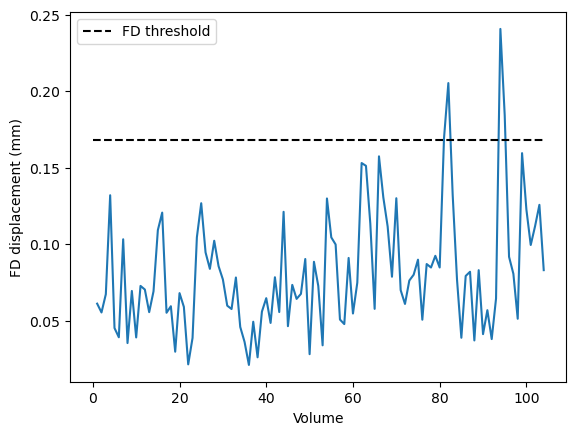

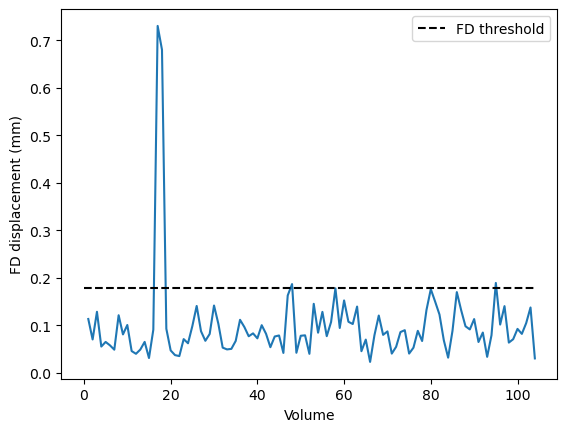

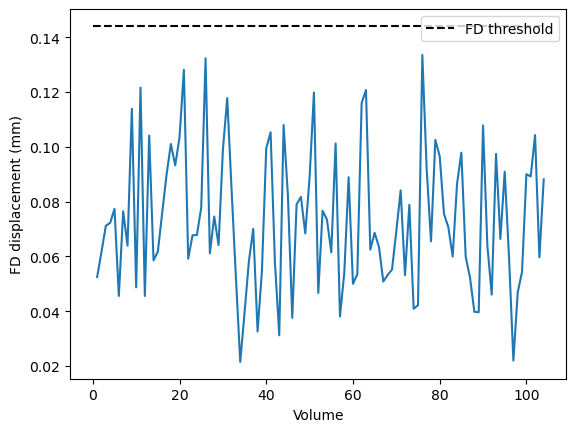

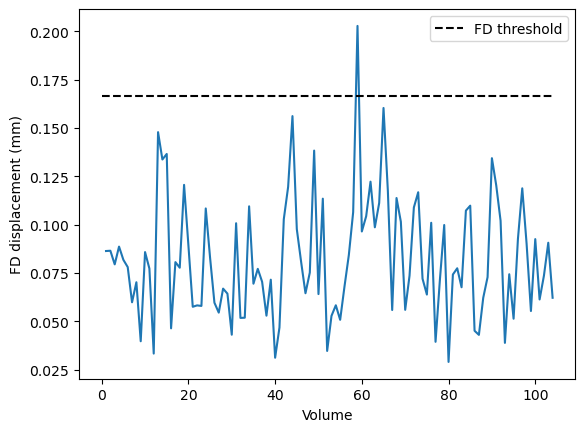

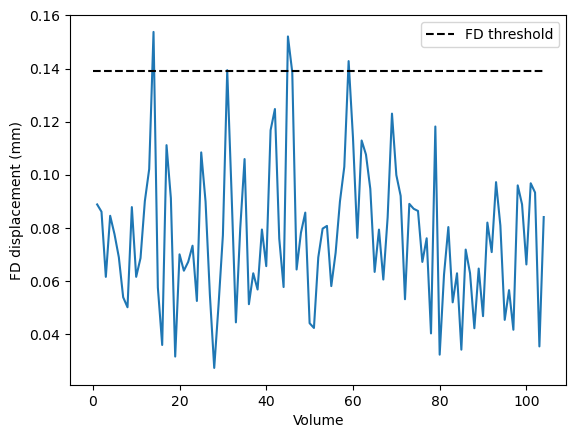

In [29]:
# ____________________ QUANTIFY THE DISPLACEMENT _________________________
import matplotlib.pyplot as plt


def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

for m in mot_params_list :
    fd = compute_FD_power(m).to_numpy()
    threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
    #%matplotlib inline
    plt.plot(list(range(1, fd.size+1)), fd)
    plt.xlabel('Volume')
    plt.ylabel('FD displacement (mm)')
    plt.hlines(threshold, 0, len(fd),colors='black', linestyles='dashed', label='FD threshold')
    plt.legend()
    plt.show()

In [30]:
"""

#Coregistration of functional to anatomica (epi_reg [FLIRT])
from fsl.wrappers import epi_reg


epi_target = op.join(preproc_root, subject_01, 'func', "{}_task-music_run-{}_bold_moco".format(subject_01, run_of_interest))
whole_t1 = op.join(bids_root, subject_01, 'anat', '{}_T1w.nii.gz'.format(subject_01))
skull_stripped_t1 = op.join(preproc_root, subject_01, 'anat', '{}_T1w'.format(subject_01))
output_path = op.join(preproc_root, subject_01,"func", "{}_task-music_run-{}_bold_MNI_space{}".format(subject_01, run_of_interest, "bbr"))
ref_vol_name =  op.join(preproc_root, subject_01, 'func', "{}_task-music_run-{}_bold_moco_mid_volume".format(subject_01, run_of_interest, "bbr"))


fslroi(epi_target, ref_vol_name, str(int(tot_volumes//2)), str(1))
white_matter_segmentation = op.join(preproc_root, subject_01, 'anat', 'sub-control01_T1w_fast_pve_2.nii.gz') # We provide the white matter segmentation

subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])

print("DONE")
"""

'\n\n#Coregistration of functional to anatomica (epi_reg [FLIRT])\nfrom fsl.wrappers import epi_reg\n\n\nepi_target = op.join(preproc_root, subject_01, \'func\', "{}_task-music_run-{}_bold_moco".format(subject_01, run_of_interest))\nwhole_t1 = op.join(bids_root, subject_01, \'anat\', \'{}_T1w.nii.gz\'.format(subject_01))\nskull_stripped_t1 = op.join(preproc_root, subject_01, \'anat\', \'{}_T1w\'.format(subject_01))\noutput_path = op.join(preproc_root, subject_01,"func", "{}_task-music_run-{}_bold_MNI_space{}".format(subject_01, run_of_interest, "bbr"))\nref_vol_name =  op.join(preproc_root, subject_01, \'func\', "{}_task-music_run-{}_bold_moco_mid_volume".format(subject_01, run_of_interest, "bbr"))\n\n\nfslroi(epi_target, ref_vol_name, str(int(tot_volumes//2)), str(1))\nwhite_matter_segmentation = op.join(preproc_root, subject_01, \'anat\', \'sub-control01_T1w_fast_pve_2.nii.gz\') # We provide the white matter segmentation\n\nsubprocess.run([\'epi_reg\',\'--epi={}\'.format(ref_vol_name

In [31]:
"""
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1)
fsleyesDisplay.load(output_path)
"""

'\nfsleyesDisplay.resetOverlays()\nfsleyesDisplay.load(skull_stripped_t1)\nfsleyesDisplay.load(output_path)\n'

In [32]:
"""
def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)

cleanup_epi_reg(op.join(preproc_root, subject_01, 'func'))
"""

"\ndef cleanup_epi_reg(path_to_clean):\n    patterns = ['*_fast_*', '*_fieldmap*']\n    for p in patterns:\n        files = glob.glob(op.join(path_to_clean, p))\n        for f in files:\n            os.remove(f)\n\ncleanup_epi_reg(op.join(preproc_root, subject_01, 'func'))\n"

In [33]:
"""
normalizing_matrix = output_path  +".mat"
if not os.path.exists(normalizing_matrix):
    print(f"Error: Anatomical file not found: {normalizing_matrix}")
else : 
    print(f"File exist : {normalizing_matrix}")
"""

'\nnormalizing_matrix = output_path  +".mat"\nif not os.path.exists(normalizing_matrix):\n    print(f"Error: Anatomical file not found: {normalizing_matrix}")\nelse : \n    print(f"File exist : {normalizing_matrix}")\n'

In [34]:
file_moco_list 

['./ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco',
 './ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-2_bold_moco',
 './ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_moco',
 './ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-4_bold_moco',
 './ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-5_bold_moco']

In [36]:
import subprocess
import os

#SMOOTHING

subject_01 = "sub-control01"
input_path = [i + ".nii.gz" for i in file_moco_list]
print(input_path)
# Define the output path for the smoothed 4D volume

output_path = ["ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-{}_bold_moco_smoothed-6mm.nii.gz".format(i) for i in range(1,6)]

for i in range(len(output_path)):
    # Construct the fslmaths command
    cmd = [
        'fslmaths',
        input_path[i],
        '-s', str(6 / 2.3548),  # Convert FWHM of 6mm to sigma for Gaussian smoothing
        output_path[i]
    ]
    
    # Run the command
    subprocess.run(cmd)
    
    print("Smoothing completed. Smoothed 4D volume saved at:", output_path)

file_moco_smooth_list = output_path
print("\nSMOOTHING DONE")



['./ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco.nii.gz', './ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-2_bold_moco.nii.gz', './ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_moco.nii.gz', './ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-4_bold_moco.nii.gz', './ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-5_bold_moco.nii.gz']
Smoothing completed. Smoothed 4D volume saved at: ['ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco_smoothed-6mm.nii.gz', 'ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-2_bold_moco_smoothed-6mm.nii.gz', 'ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_moco_smoothed-6mm.nii.gz', 'ds000171/derivatives/prepr

In [38]:
import nibabel as nib
import numpy as np

data = []
for file_path in file_moco_smooth_list:
    nii = nib.load(file_path)
    data.append(nii.get_fdata())

# Concatenate the data arrays along the 4th dimension
concatenated_data = np.concatenate(data, axis=3)

# Create a new NIfTI image
concatenated_img = nib.Nifti1Image(concatenated_data, nii.affine)

# Save the concatenated image
nib.save(concatenated_img, op.join(preproc_root, subject_01, 'func','concatenated_run_moco_smooth.nii.gz'))

In [ ]:
import pandas as pd
# Function to concatenate the table multiple times with adjusted onset values
tsv_file_path = "ds000171/sub-control01/func/sub-control01_task-music_run-1_events.tsv"
table_of_times= pd.read_csv(tsv_file_path, sep='\t')
table_of_times
def concatenate_with_adjusted_onset(df, times):
    concatenated_data = []
    max_onset = 0

    for _ in range(times):

        df_copy = df.copy()
        df_copy['onset'] += max_onset
        concatenated_data.append(df_copy)

        max_onset = df_copy['onset'].max() + 3
    result = pd.concat(concatenated_data, ignore_index=True)

    return result, concatenated_data
concatenated_table, list_data = concatenate_with_adjusted_onset(table_of_times, 5)
#list_data 
#concatenated_table
concatenated_table.to_csv('concatenated_table.csv', index=False)


In [ ]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=3,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(image,concatenated_table)


In [ ]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

In [ ]:


# Create the dictionary of the conditions

conditions = {
    'negative': np.array([1, 0, 0, 0, 0]), # Specify the np array, e.g. np.array([2, -1, 0]) to extract active
    'positive':np.array([0, 1, 0, 0, 0]),
    'reponse':np.array([0, 0, 1, 0, 0]),
    'tones':np.array([0, 0, 0, 1, 0])
}

positive_minus_negative = conditions['positive'] - conditions['negative']
positive_minus_negative



In [ ]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(positive_minus_negative, design_matrix=fmri_glm.design_matrices_[0])  ####TODO ADD COLOR SCALE


In [ ]:
import nibabel as nib
z_map = fmri_glm.compute_contrast(positive_minus_negative,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

In [ ]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(image), # est ce que ça pourrait engendrer des trucs ici ?
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=1.0,
              display_mode='z', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title='Positive minus negative (Z>3)')
plt.show()

In [ ]:


from nilearn.glm import threshold_stats_img

#Link to threshold_stats_img function documentation
#https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html

cluster_size = 10 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.05 # Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title='Active minus Rest (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()

